# Mask R-CNN demo

This notebook illustrates one possible way of using `maskrcnn_benchmark` for computing predictions on images from an arbitrary URL.

Let's start with a few standard imports

In [1]:
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab

import requests
from io import BytesIO
from PIL import Image
import numpy as np
import cv2

In [2]:
# this makes our figures bigger
pylab.rcParams['figure.figsize'] = 20, 12

Those are the relevant imports for the detection model

In [3]:
from maskrcnn_benchmark.config import cfg
from predictor import COCODemo

We provide a helper class `COCODemo`, which loads a model from the config file, and performs pre-processing, model prediction and post-processing for us.

We can configure several model options by overriding the config options.
In here, we make the model run on the CPU

In [4]:
config_file = "/workspace/maskrcnn-benchmark/configs/caffe2/e2e_mask_rcnn_R_50_FPN_1x_caffe2.yaml"

# update the config options with the config file
cfg.merge_from_file(config_file)
# manual override some options
cfg.merge_from_list(["MODEL.DEVICE", "cpu"])

Now we create the `COCODemo` object. It contains a few extra options for conveniency, such as the confidence threshold for detections to be shown.

In [ ]:
coco_demo = COCODemo(
    cfg,
    min_image_size=800,
    confidence_threshold=0.7,
)

Let's define a few helper functions for loading images from a URL

In [29]:
def load(url):
    """
    Given an url of an image, downloads the image and
    returns a PIL image
    """
    response = requests.get(url)
    pil_image = Image.open(BytesIO(response.content)).convert("RGB")
    # convert to BGR format
    image = np.array(pil_image)[:, :, [2, 1, 0]]
    return image

def imshow(img):
    plt.imshow(img[:, :, [2, 1, 0]])
    plt.axis("off")

Let's now load an image from the COCO dataset. It's reference is in the comment

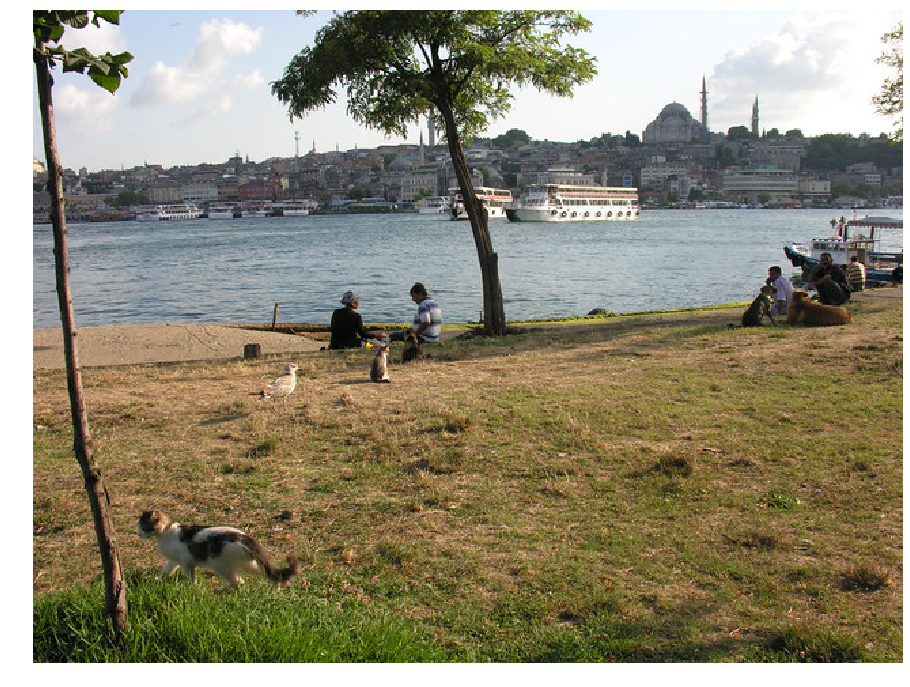

In [30]:
# from http://cocodataset.org/#explore?id=345434
image = load("http://farm3.staticflickr.com/2469/3915380994_2e611b1779_z.jpg")
imshow(image)

### Computing the predictions

We provide a `run_on_opencv_image` function, which takes an image as it was loaded by OpenCV (in `BGR` format), and computes the predictions on them, returning an image with the predictions overlayed on the image.

In generalized rcnn: initial proposals= 1000
In ROI Head: detections size= 32
In ROI Head: After updating loss box detections= 32
In ROIKeypointHead: Length of proposals before post processor= 32
In ROIKeypointHead: Length of proposals after post processor= 32
In predictor: length of proposals 32


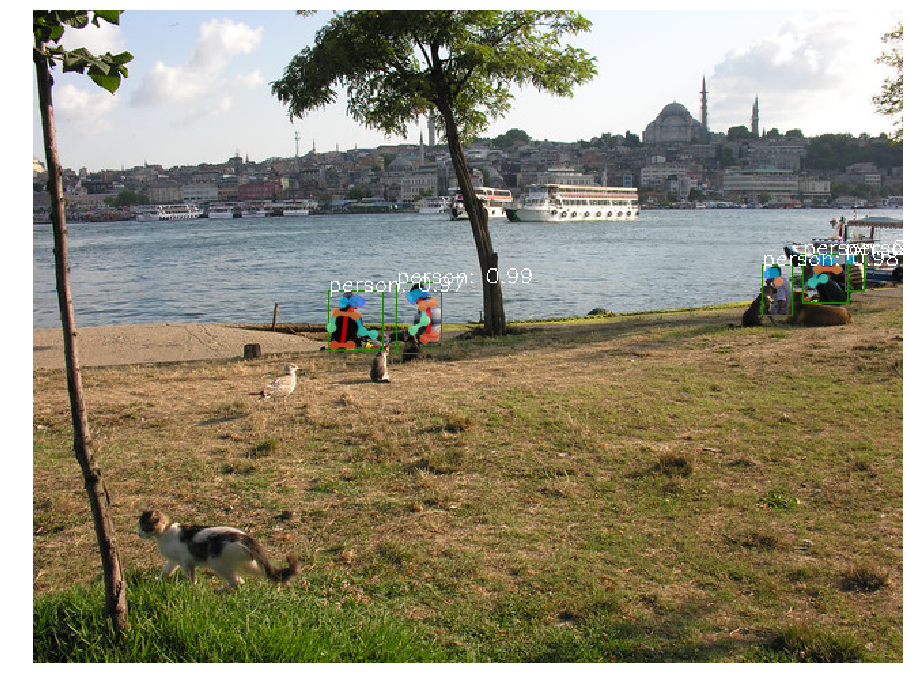

In [31]:
# compute predictions
predictions = coco_demo.run_on_opencv_image(image)
imshow(predictions)

## Keypoints Demo

In [4]:
# set up demo for keypoints
config_file = "/workspace/maskrcnn-benchmark/configs/caffe2/e2e_keypoint_rcnn_R_50_FPN_1x_caffe2.yaml"
cfg.merge_from_file(config_file)
cfg.merge_from_list(["MODEL.DEVICE", "cpu"])
cfg.merge_from_list(["MODEL.MASK_ON", False])

coco_demo = COCODemo(
    cfg,
    min_image_size=800,
    confidence_threshold=0.7,
)

In [ ]:
# run demo
image = load("http://farm9.staticflickr.com/8419/8710147224_ff637cc4fc_z.jpg")
predictions = coco_demo.run_on_opencv_image(image)
imshow(predictions)

In [5]:
def load_ucf(path):
    pil_image = Image.open(path).convert("RGB")
    # convert to BGR format
    image = np.array(pil_image)[:, :, [2, 1, 0]]
    return image

def imshow(img):
    plt.imshow(img[:, :, [2, 1, 0]])
    plt.axis("off")

In predictor: length of proposals 5


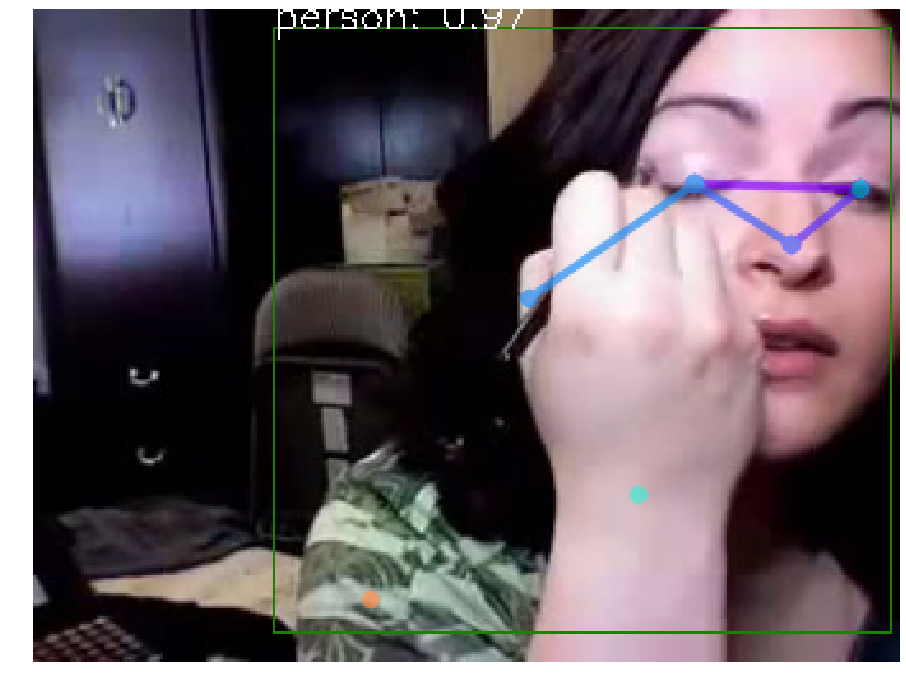

In [7]:
# run demo
image = load_ucf("ucf_test_img.jpg")
predictions = coco_demo.run_on_opencv_image(image)
imshow(predictions)

## Multi-batch inference

In [6]:
import torch

transforms = coco_demo.build_transform()
img_tensors_list=[]
for i in range(2):
    img_path= 'ucf_test_img.jpg'
    np_img=load_ucf(img_path)
    tensor_img=transforms(np_img)
    img_tensors_list.append(tensor_img)
        
# inp_tensor = torch.stack(img_tensors_list, dim=0)

In [7]:
from maskrcnn_benchmark.structures.image_list import to_image_list
from maskrcnn_benchmark.modeling.detector import build_detection_model
from maskrcnn_benchmark.utils.checkpoint import DetectronCheckpointer

device = torch.device(cfg.MODEL.DEVICE)

model = build_detection_model(cfg)
model.eval()
model.to(device)

save_dir = cfg.OUTPUT_DIR
checkpointer = DetectronCheckpointer(cfg, model, save_dir=save_dir)
_ = checkpointer.load(cfg.MODEL.WEIGHT)

In [8]:
# img_tensors_list = img_tensors_list[0]
image_list = to_image_list(img_tensors_list, cfg.DATALOADER.SIZE_DIVISIBILITY)
image_list = image_list.to(device)

In [9]:
with torch.no_grad():
    predictions, proposals = model(image_list,True)

In [14]:
proposal=proposals[0]
type(proposal)

maskrcnn_benchmark.structures.bounding_box.BoxList

In [15]:
len(proposal)

5

In [13]:
len(proposals)

2

In [81]:
predictions.size()

torch.Size([10, 17, 56, 56])

In [15]:
for proposal in proposals:
    print(len(proposal)) 
    bbox = proposal.bbox
    print(bbox.size())

5
torch.Size([5, 4])
5
torch.Size([5, 4])


In [17]:
scores = proposals[0].get_field("scores")
print(scores)
keep = torch.nonzero(scores > 0.7).squeeze(1)
keep

tensor([0.9727, 0.5154, 0.2651, 0.0746, 0.1071])


tensor([0])

In [17]:
len(keep)

1

### Splitting predictions per image, keeping high confidence proposals 

In [18]:
boxes_per_image = [box.bbox.size(0) for box in proposals]
predictions_pi = predictions.split(boxes_per_image, dim=0)

In [53]:
# wrong since not sure that each image will have same number of box proposals
predictions_pi = torch.stack(list(predictions_pi), dim=0)

In [19]:
predictions_pi.size()

AttributeError: 'tuple' object has no attribute 'size'

In [10]:
scores = [proposal.get_field("scores") for proposal in proposals]
scores = [score == torch.max(score) for score in scores]
scores = torch.cat(scores, dim=0)
print(scores)

tensor([1, 0, 0, 0, 0, 1, 0, 0, 0, 0], dtype=torch.uint8)


In [11]:
predictions[scores,:,:,:].shape

torch.Size([2, 17, 56, 56])

In [21]:
scores_pi = scores.split(boxes_per_image, dim=0)
scores_pi.size()

AttributeError: 'tuple' object has no attribute 'size'

### Combining each keypoint prediction into a complete image

In [24]:
predictions_pi_tup = predictions.split(boxes_per_image, dim=0)
scores_pi_tup = scores.split(boxes_per_image, dim=0)

In [109]:
for prediction, score, proposal in zip(predictions_pi_tup, scores_pi_tup, proposals):
    bbox = proposal.bbox
    
    keep_prop_score = torch.nonzero(score > 0.7).squeeze(1)
    prediction = prediction[keep_prop_score]
    bbox = bbox[keep_prop_score]
    
    prediction = torch.exp(prediction)
    
    heatmap_channels = np.ones(((17,) + proposal.size[::-1]))*0.000001
    print('proposal shape', heatmap_channels.shape)
    for pred, box in zip(prediction, bbox):
        print(box.to(torch.int64))
        box = box.to(torch.int64).numpy()
        print(pred.size())
        
        pred = np.transpose(pred.numpy(), [1,2,0])
        resized_pred = cv2.resize(
            pred, (box[2] - box[0], box[3]-box[1]), interpolation=cv2.INTER_CUBIC
        )
        resized_pred = np.transpose(resized_pred, [2,0,1])
        
        print('resized shape:', resized_pred.shape)
        print(box[0], box[2])
        print(heatmap_channels[:, box[1]:box[3], box[0]:box[2]].shape)
        
        heatmap_channels[:, box[1]:box[3], box[0]:box[2]] += resized_pred
        
    print(proposal.size)
    print(prediction.size())
    print(score.size())
    print(proposal.bbox.size())

proposal shape (17, 800, 1062)
tensor([ 296,   22, 1050,  765])
torch.Size([17, 56, 56])
resized shape: (17, 743, 754)
296 1050
(17, 743, 754)
(1062, 800)
torch.Size([1, 17, 56, 56])
torch.Size([5])
torch.Size([5, 4])
proposal shape (17, 800, 1062)
tensor([ 296,   22, 1050,  765])
torch.Size([17, 56, 56])
resized shape: (17, 743, 754)
296 1050
(17, 743, 754)
(1062, 800)
torch.Size([1, 17, 56, 56])
torch.Size([5])
torch.Size([5, 4])


In [67]:
ar = np.array([1,2,3])
ar

array([1, 2, 3])

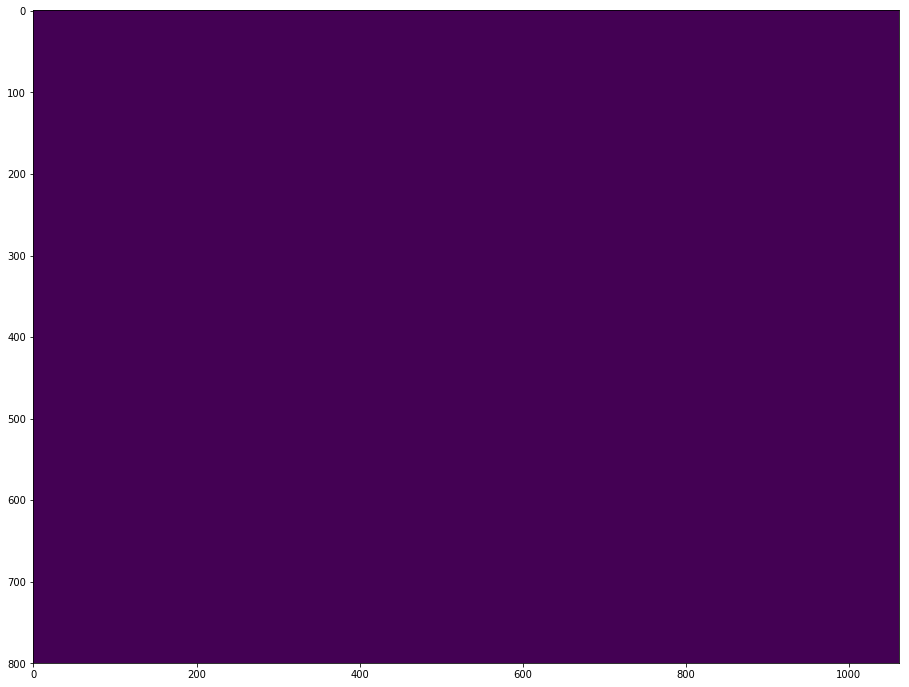

In [92]:
art = np.ones((800, 1062))*-14
plt.figure()
plt.imshow(art)

In [70]:
ar[::-1]

array([3, 2, 1])

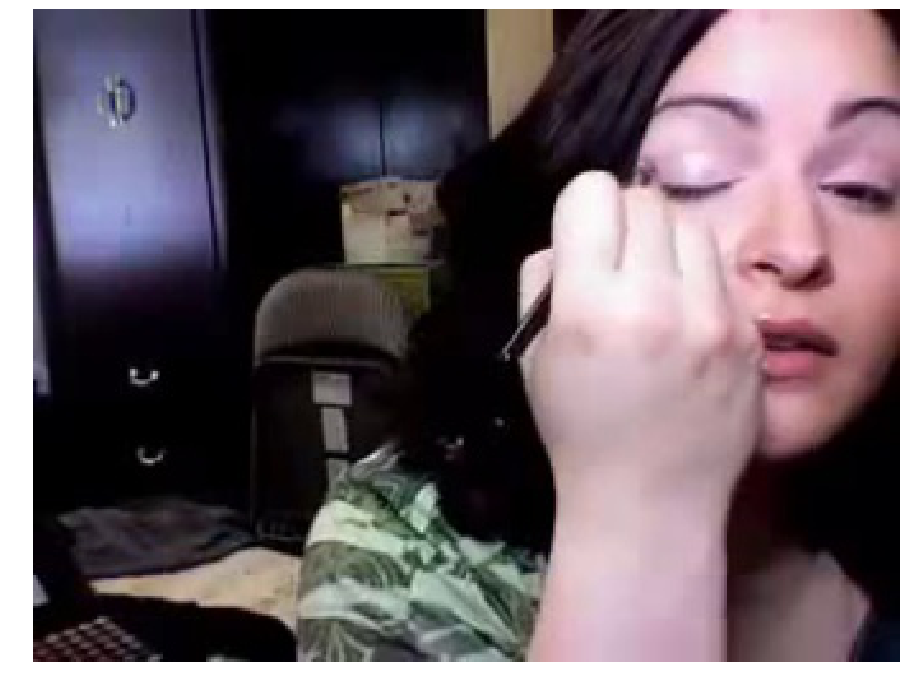

In [25]:
np_img=load_ucf('ucf_test_img.jpg')
imshow(np_img)

max at 0 tensor(9.0277)
max at 1 tensor(8.0709)
max at 2 tensor(7.7282)
max at 3 tensor(-2.5384)
max at 4 tensor(5.6615)
max at 5 tensor(0.3011)
max at 6 tensor(1.9888)
max at 7 tensor(-4.1527)
max at 8 tensor(-0.1287)
max at 9 tensor(1.1362)
max at 10 tensor(2.9147)
max at 11 tensor(-3.8318)
max at 12 tensor(-2.5008)
max at 13 tensor(-2.3605)
max at 14 tensor(0.5778)
max at 15 tensor(-2.4081)
max at 16 tensor(-1.6460)


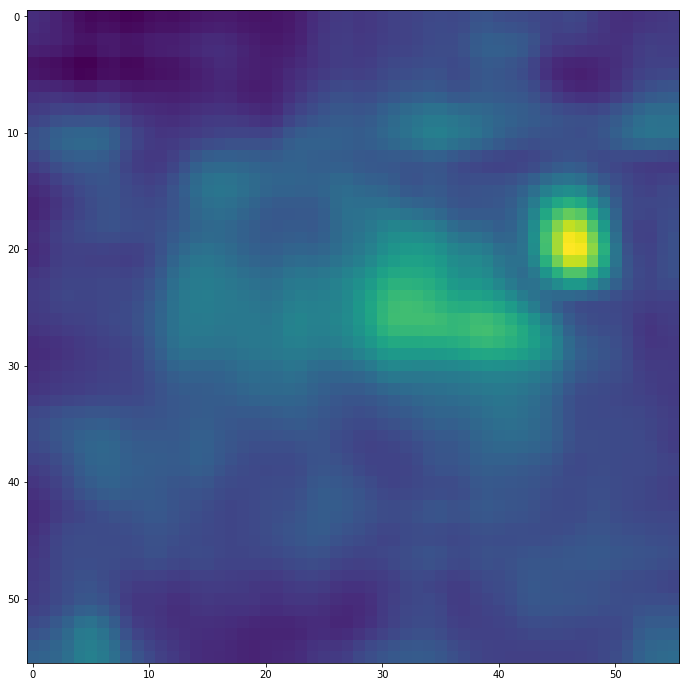

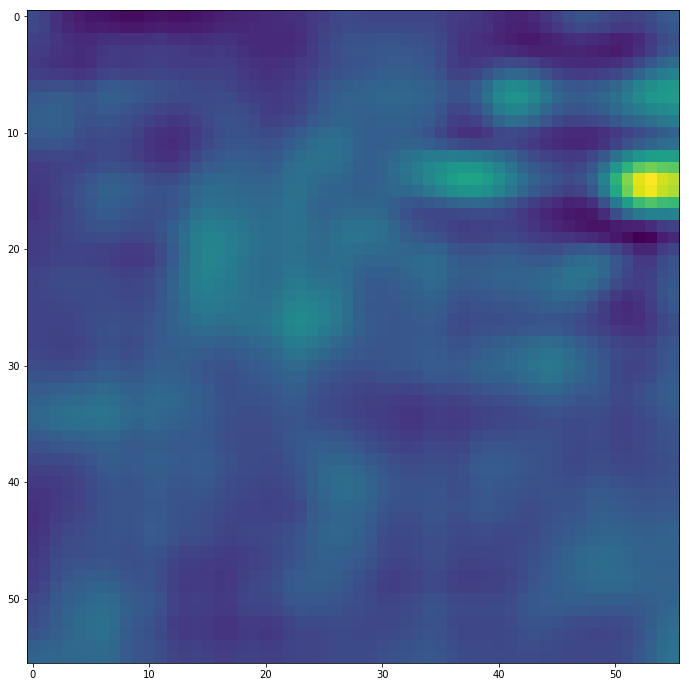

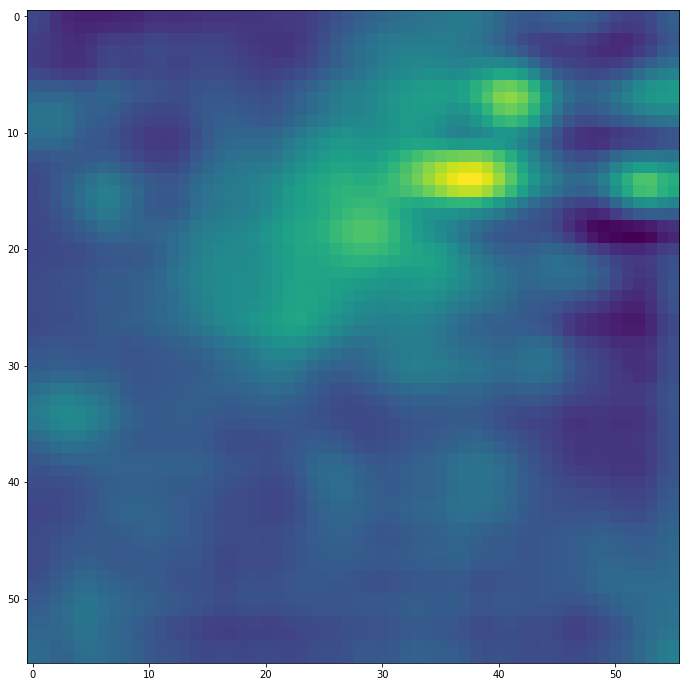

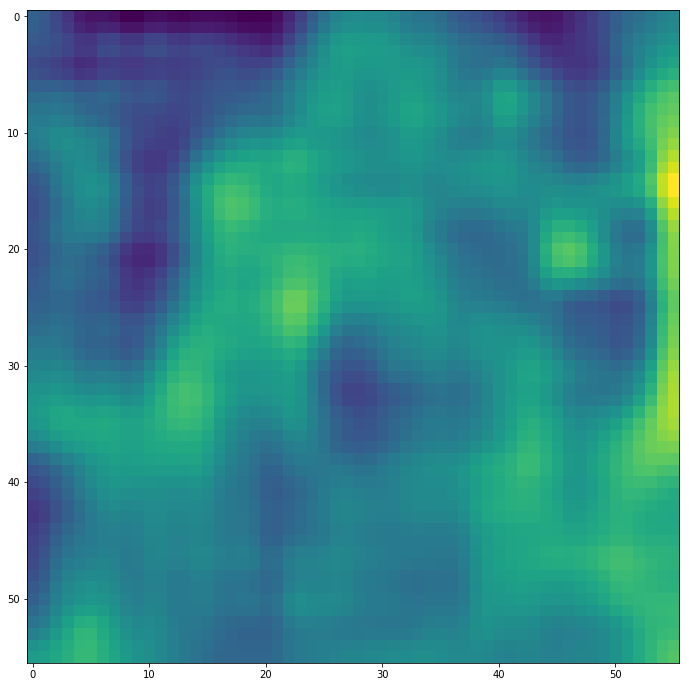

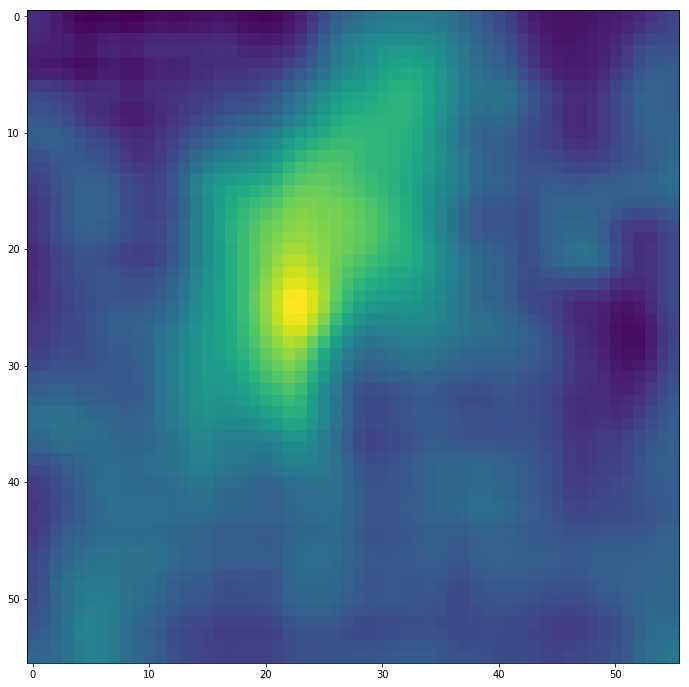

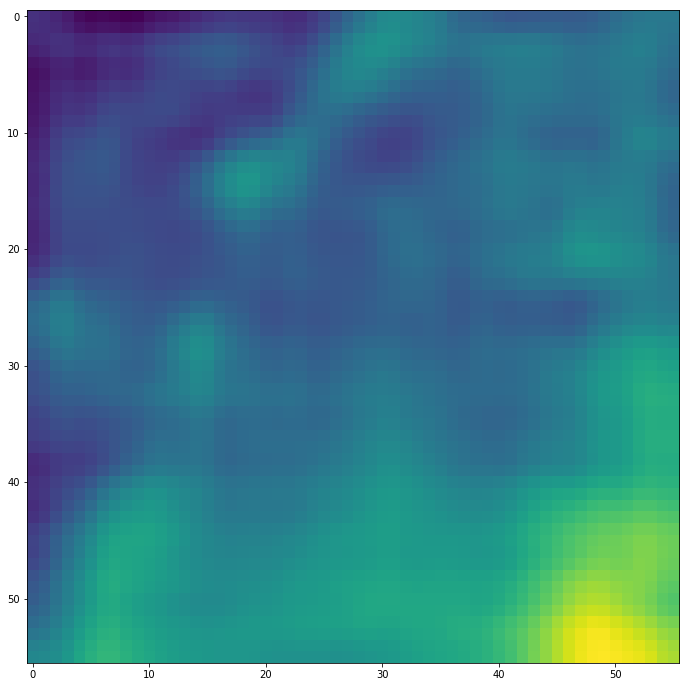

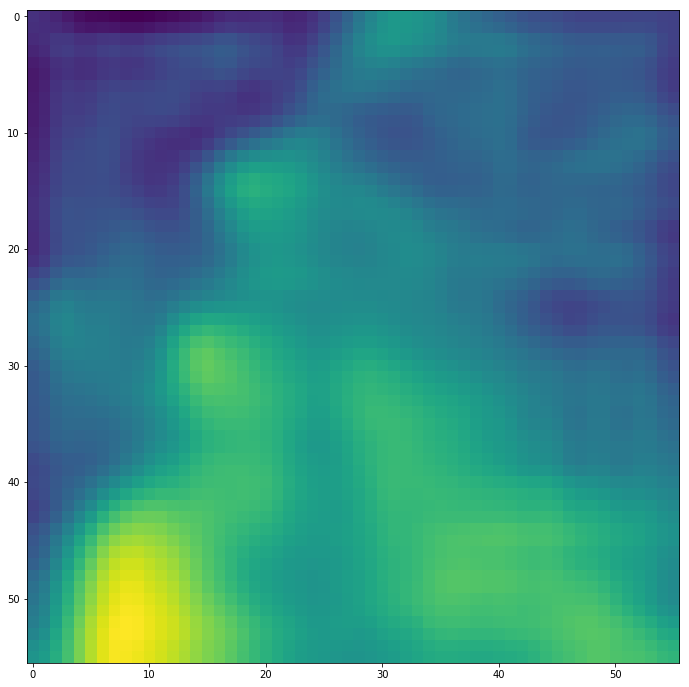

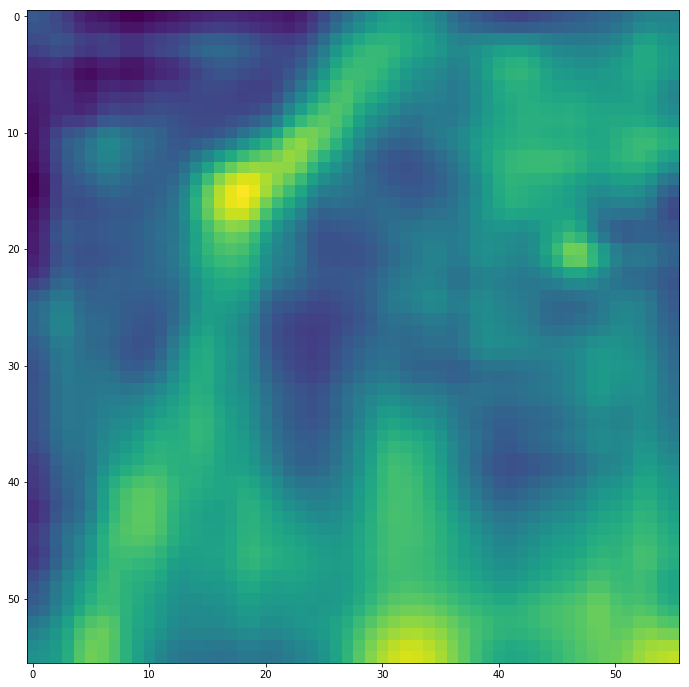

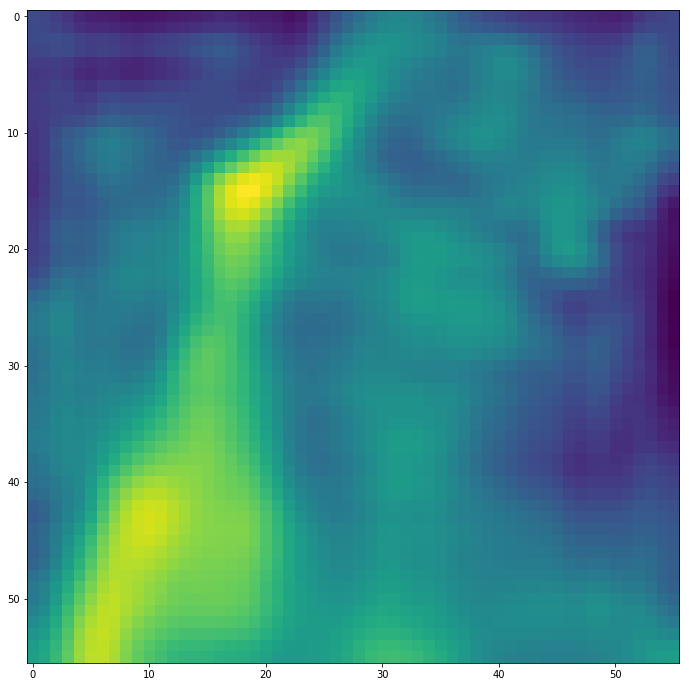

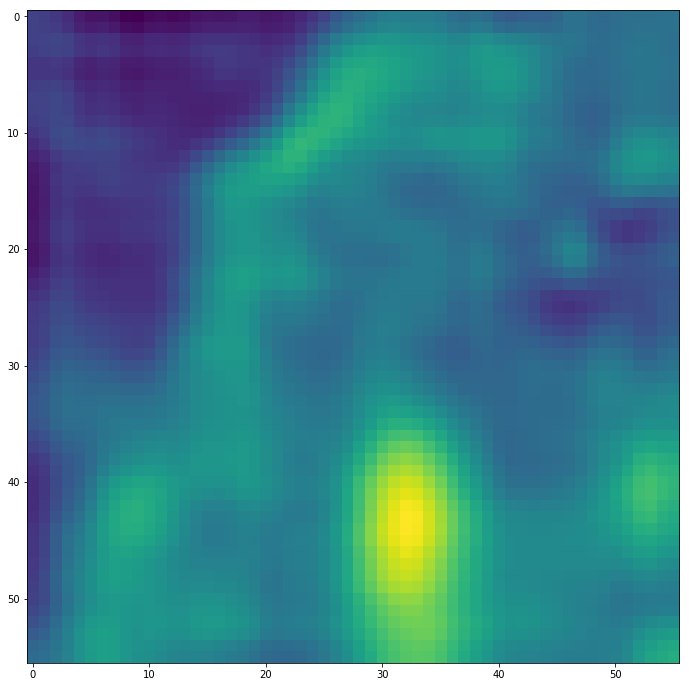

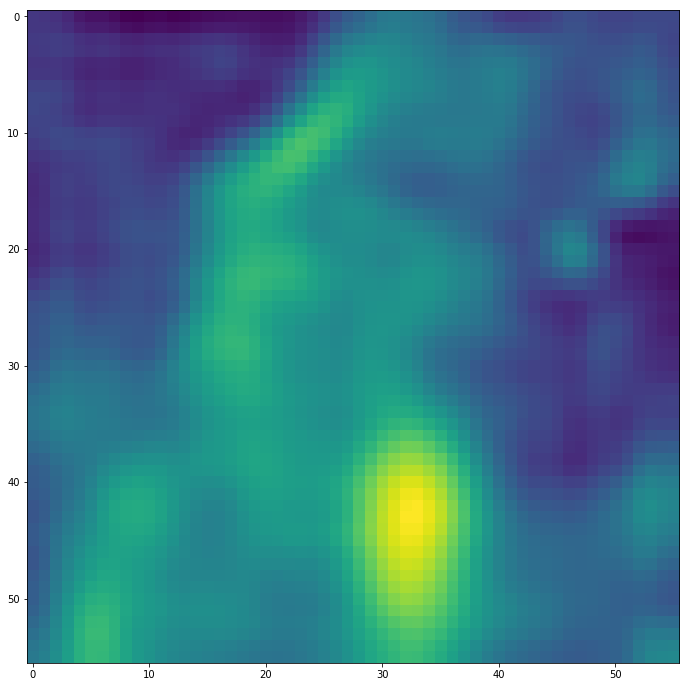

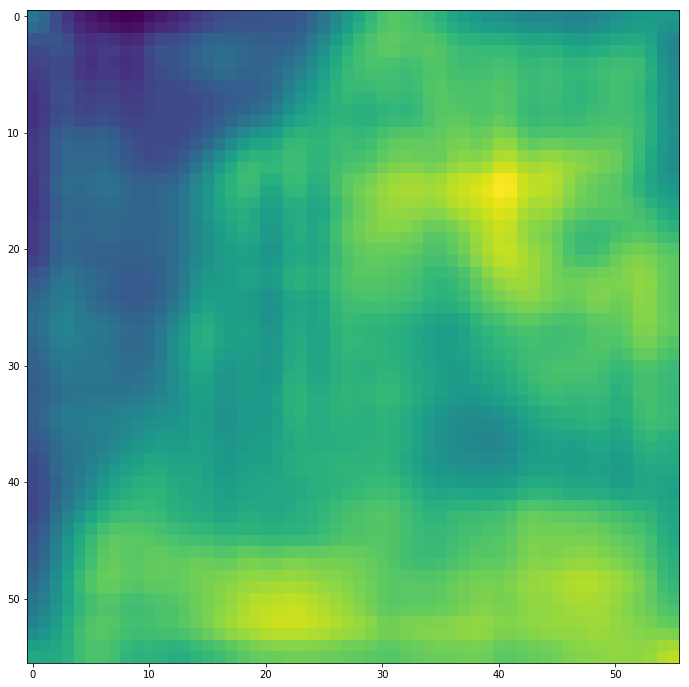

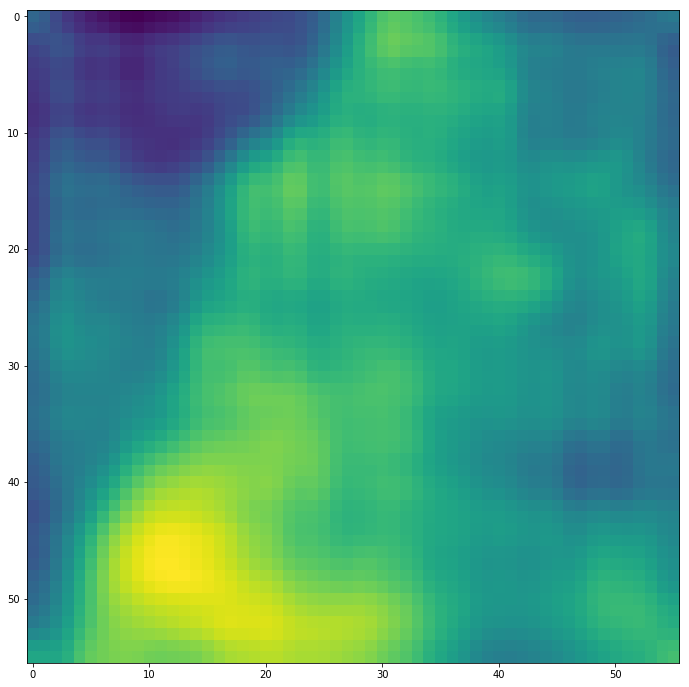

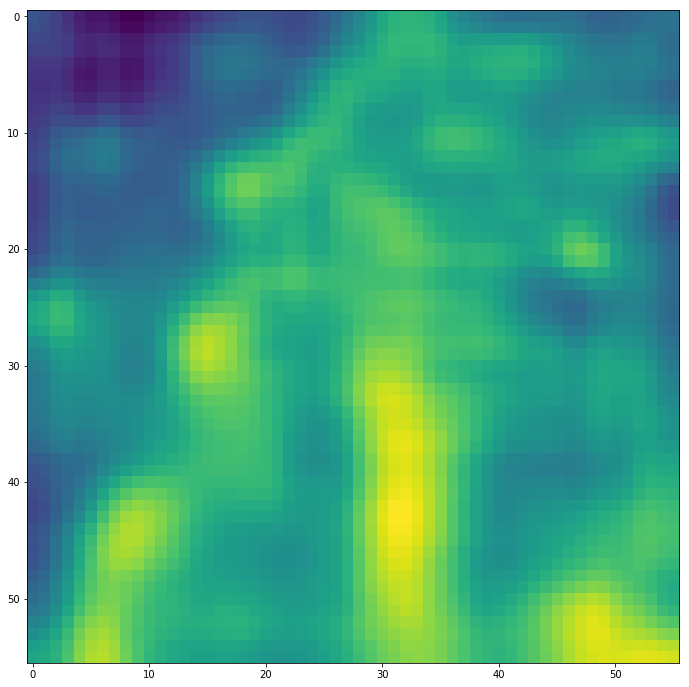

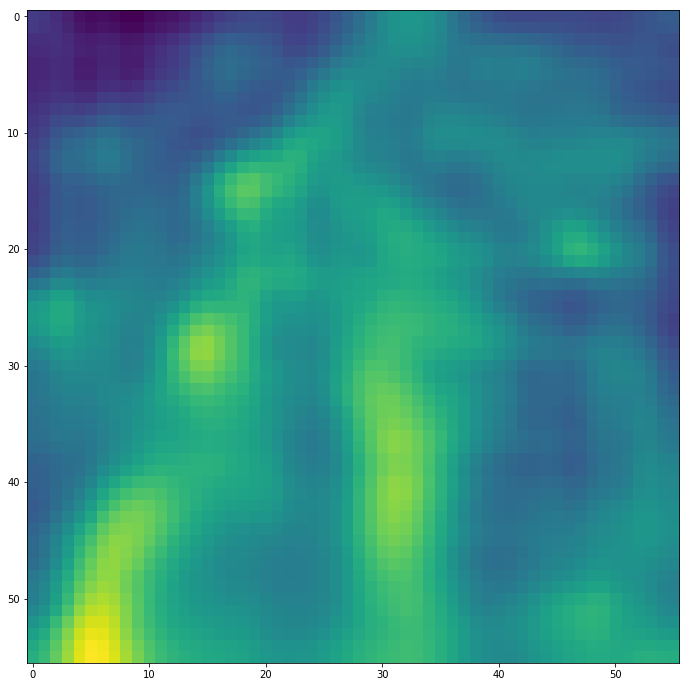

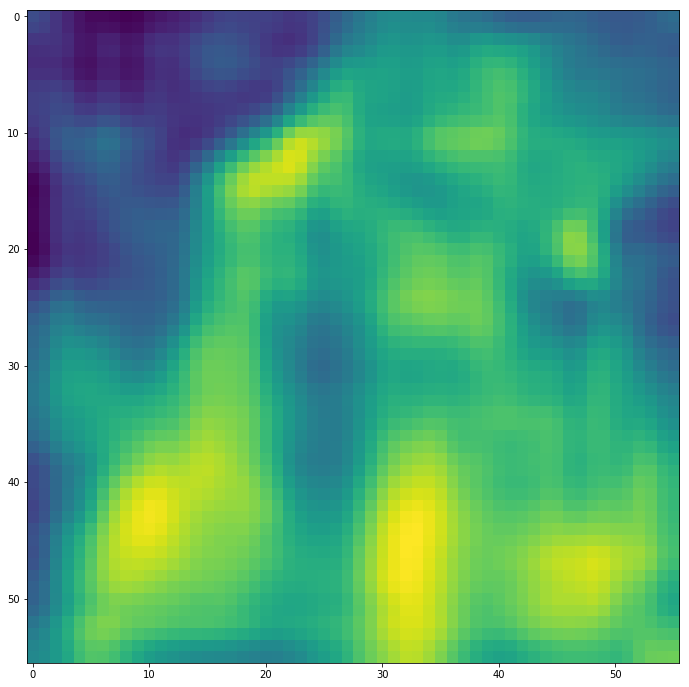

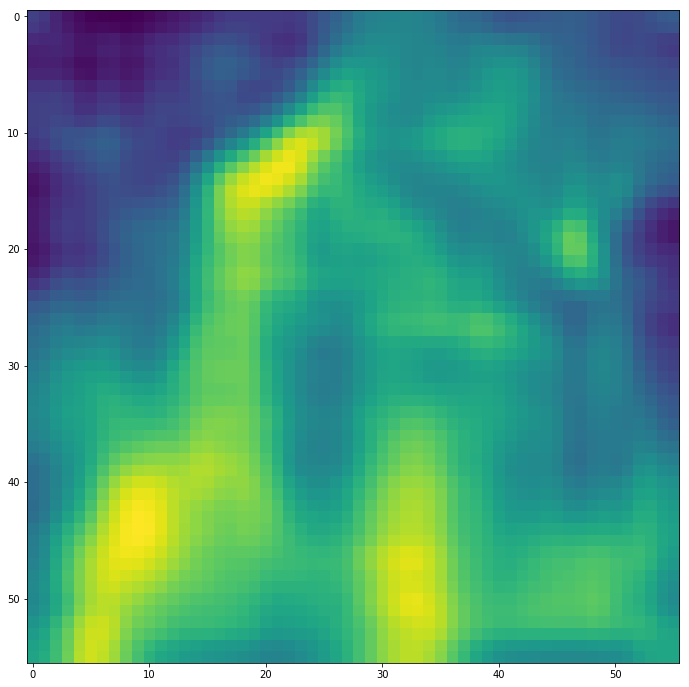

In [116]:
prediction=predictions[0]
prediction_plus=torch.zeros(56,56)
# prediction_plus = prediction_plus.double()
for i in range(17):
    print('max at ' + str(i), torch.max(prediction[i]))
    plt.figure()
    plt.imshow(prediction[i])
    if torch.max(prediction[i]) > 2:
        prediction_plus = prediction_plus + prediction[i]

In [112]:
heatmap_channels = np.log(heatmap_channels)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


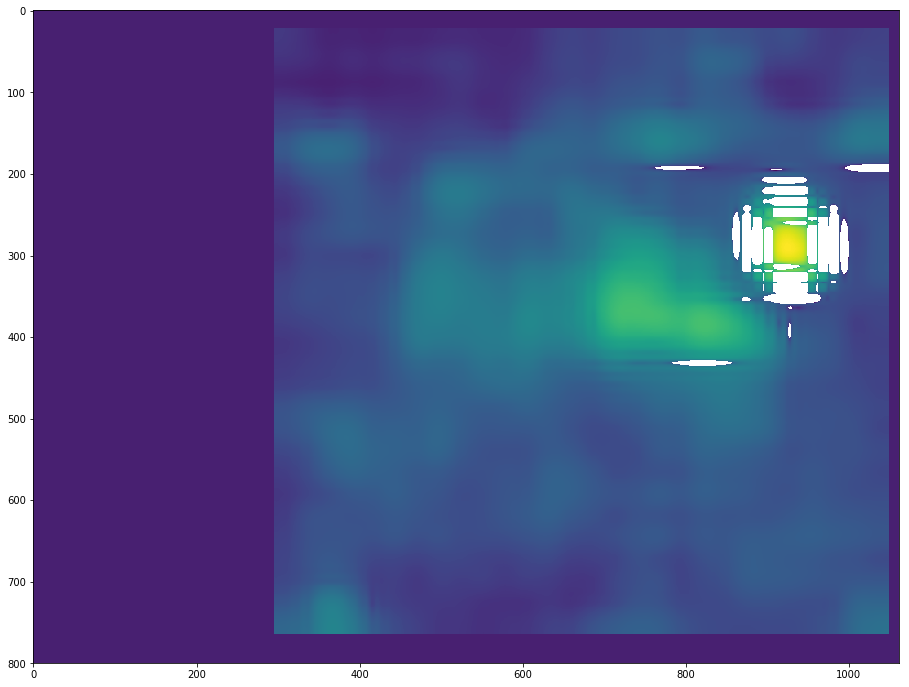

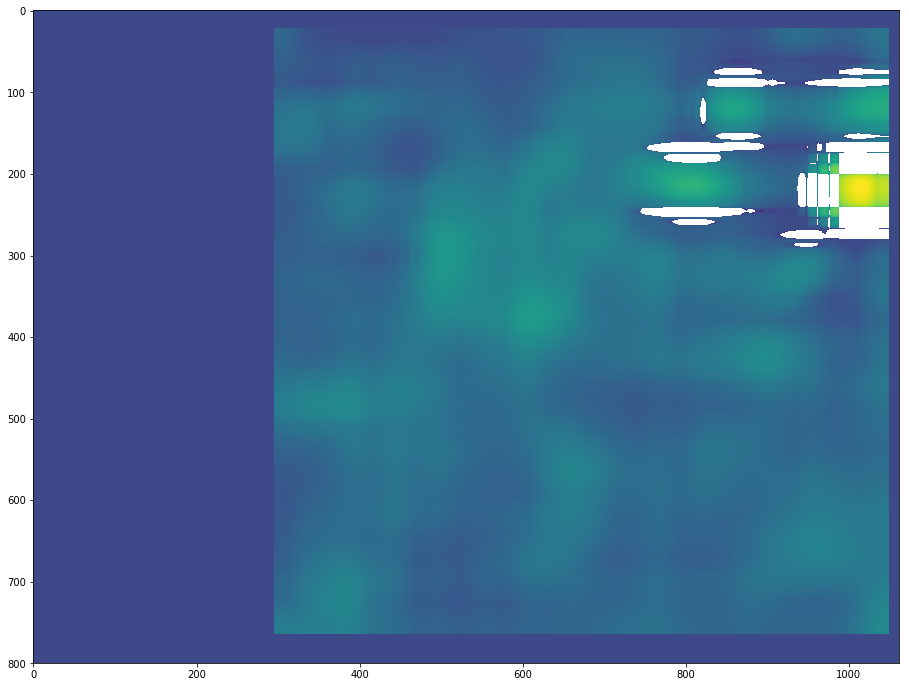

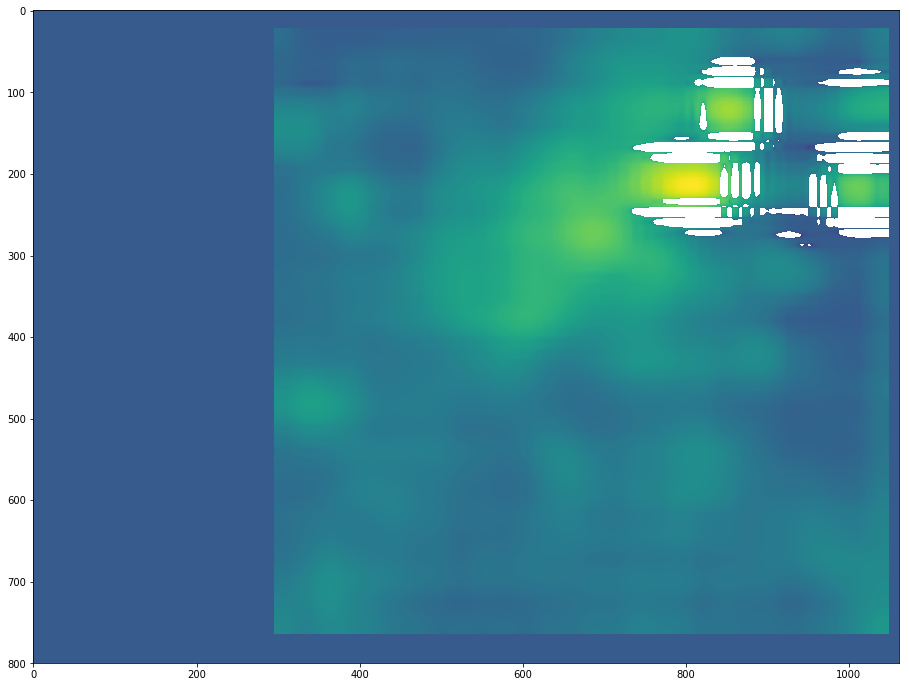

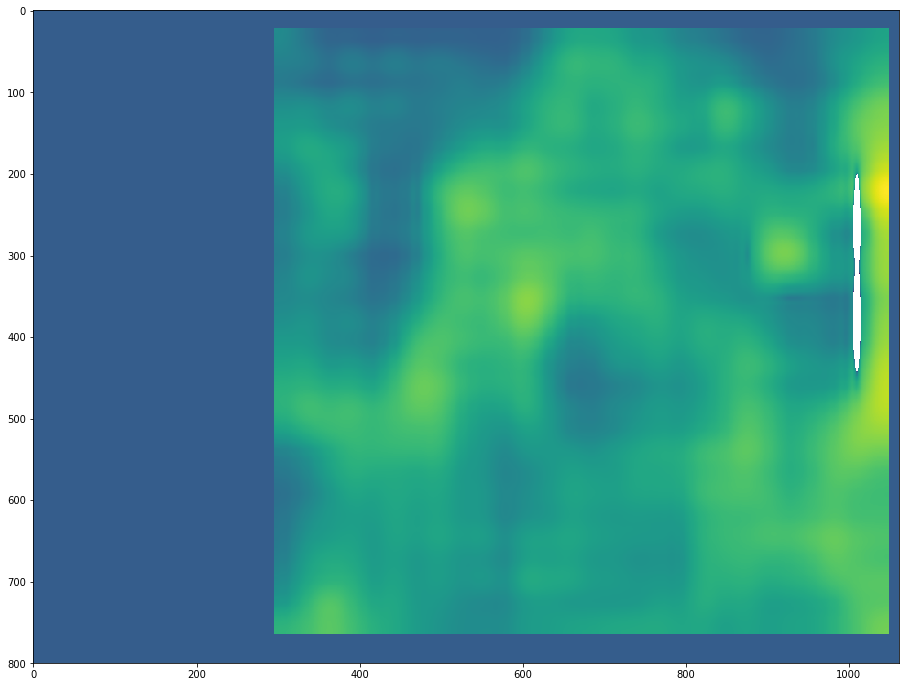

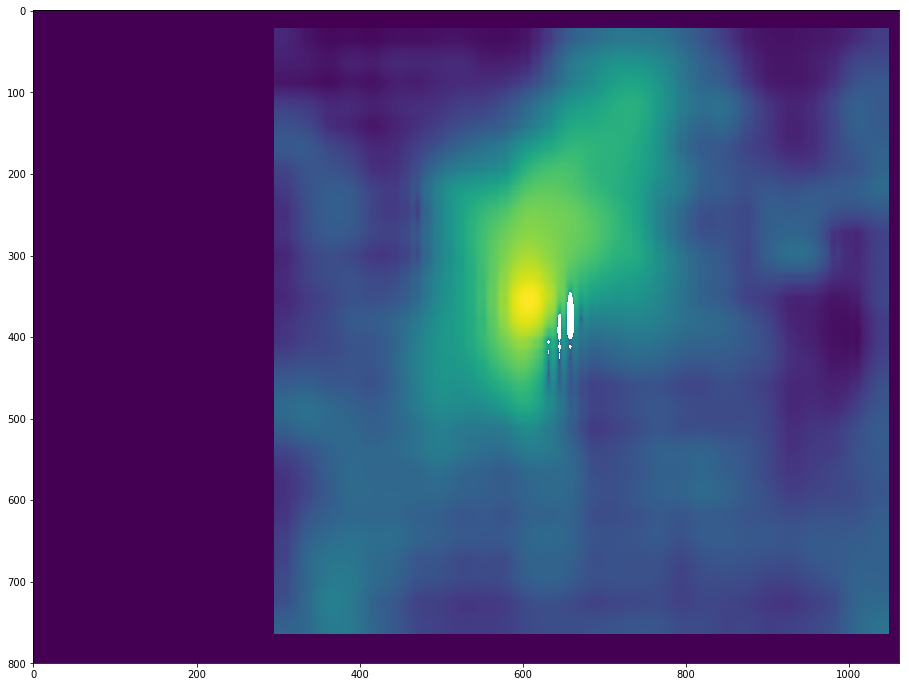

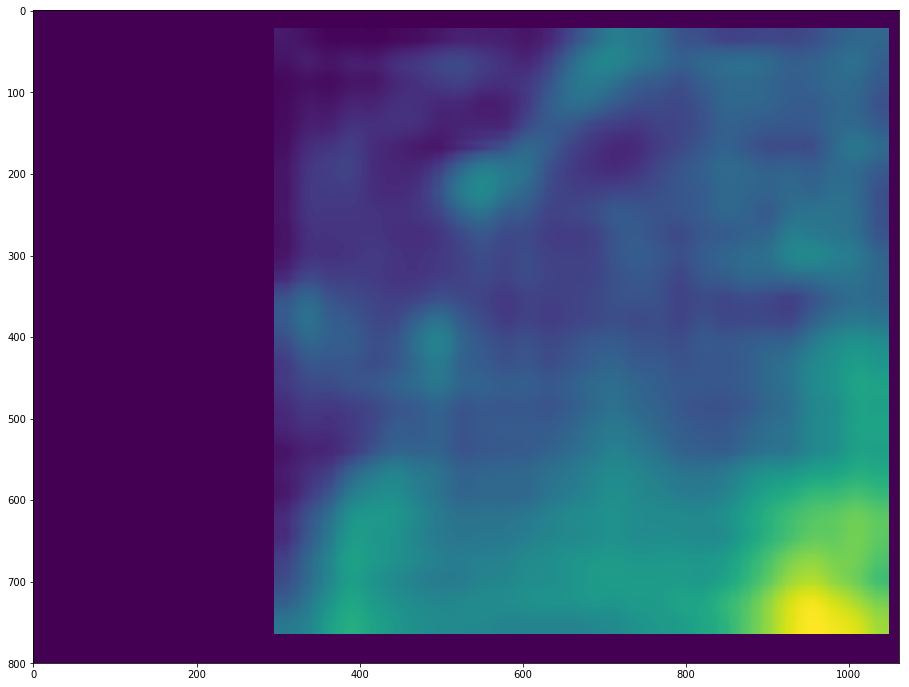

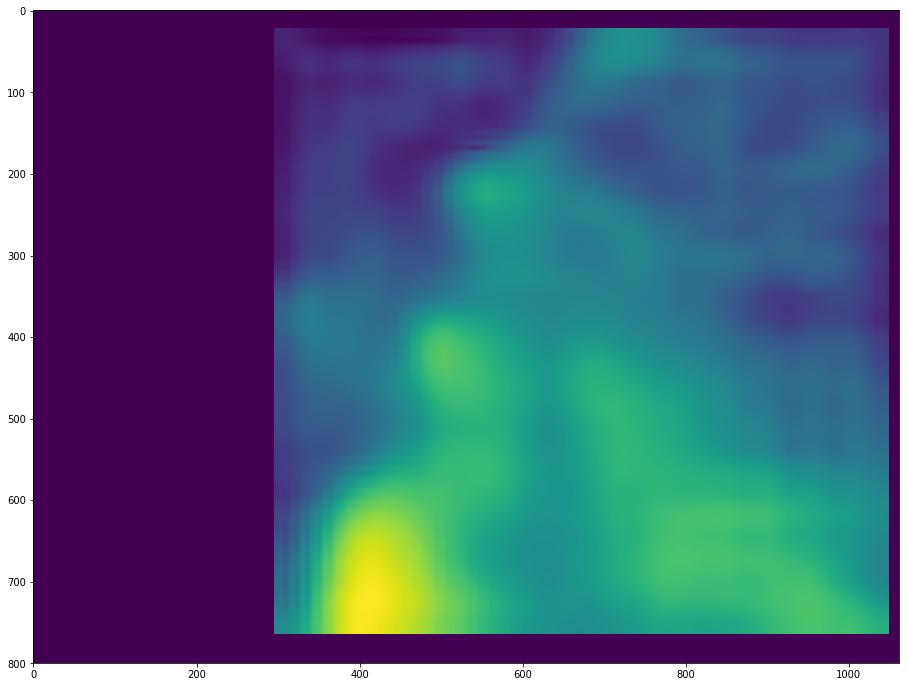

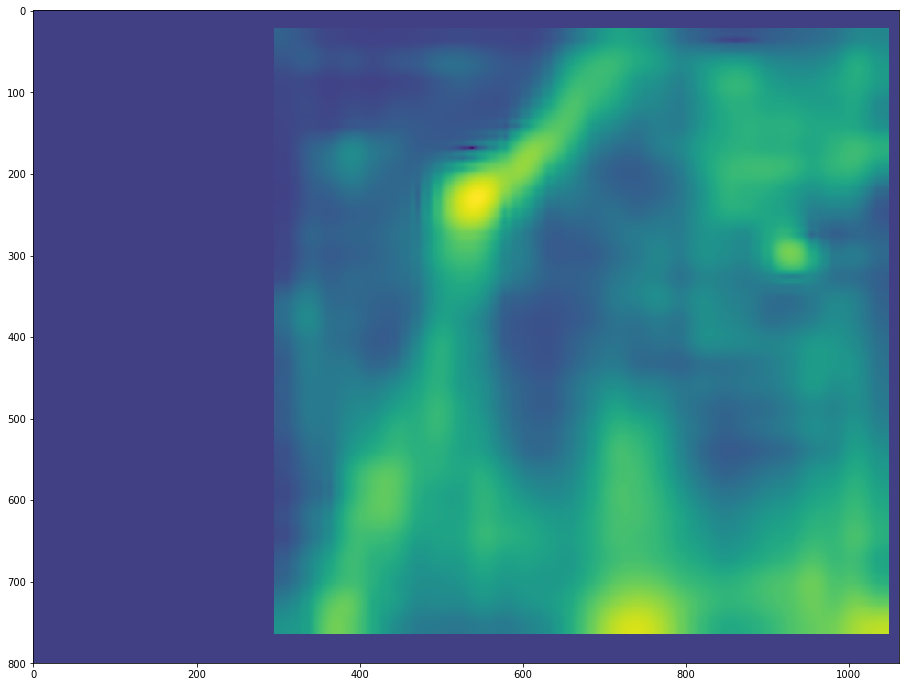

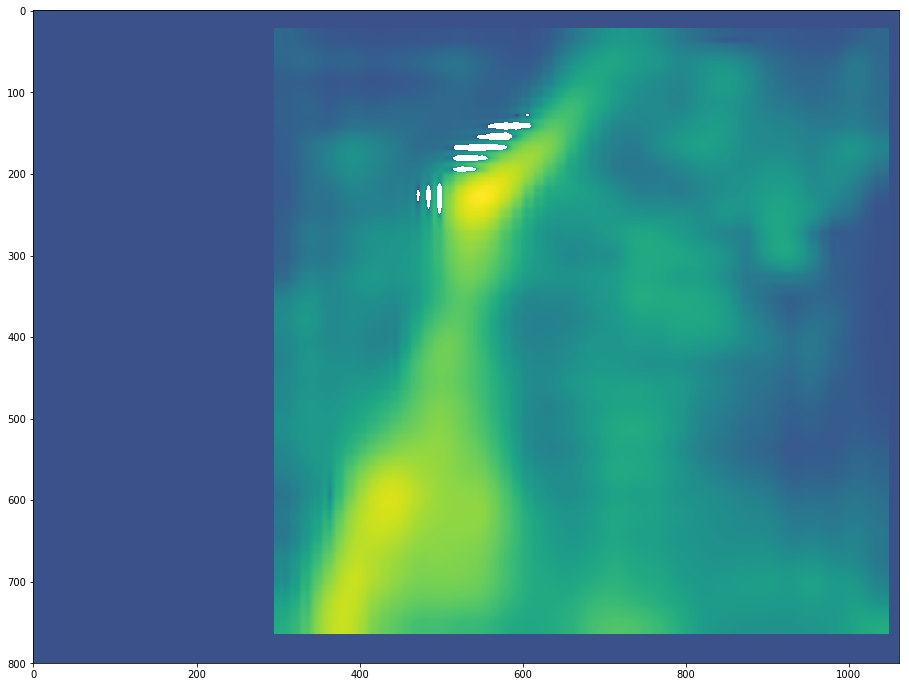

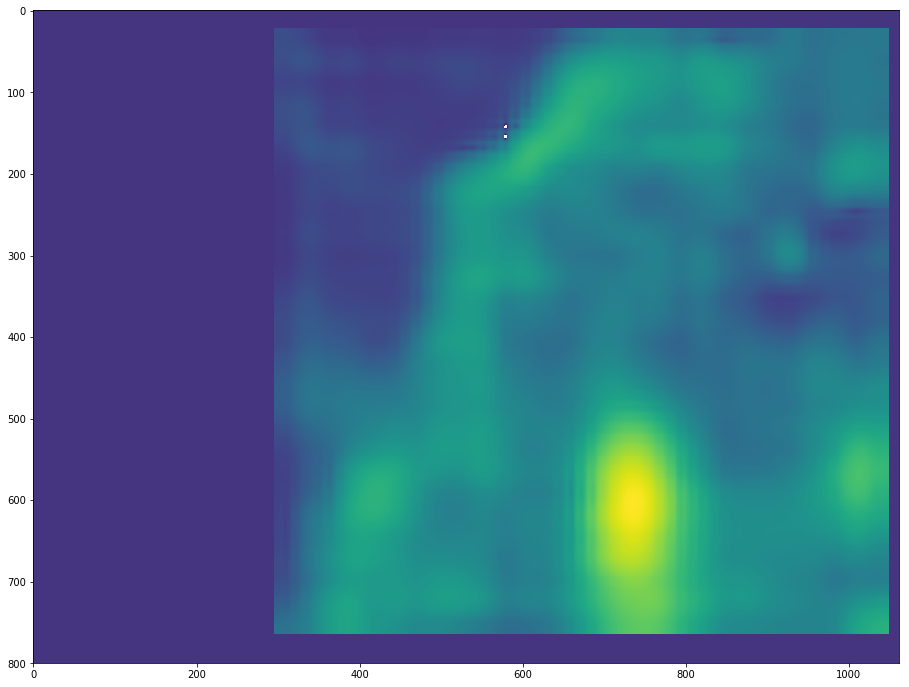

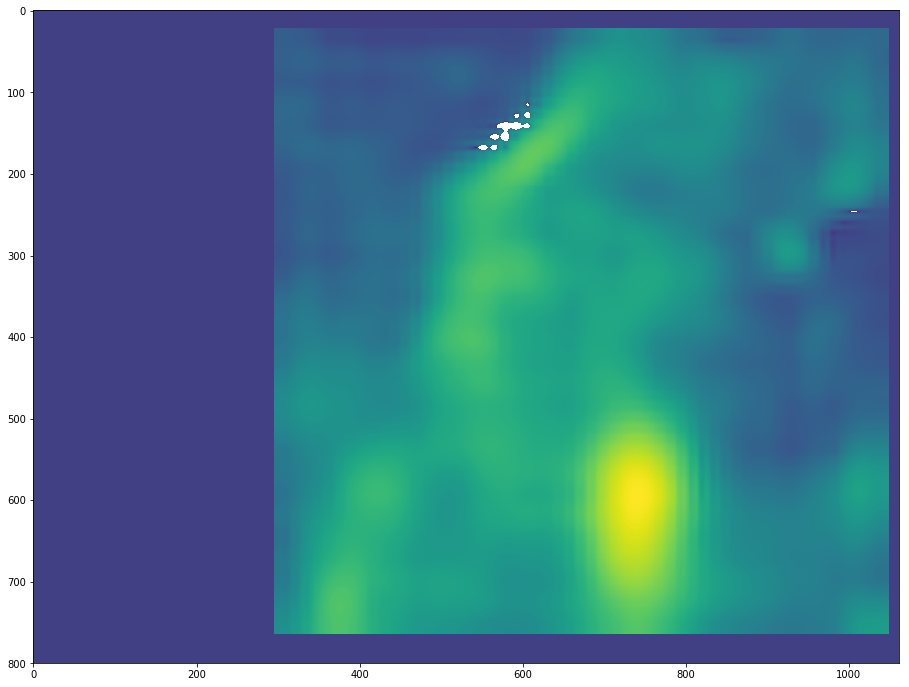

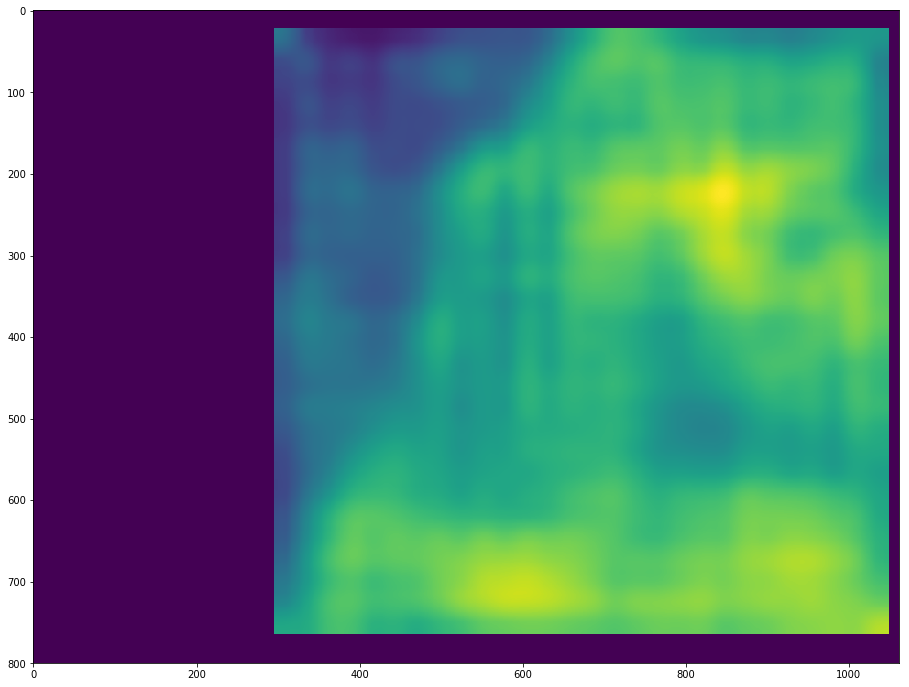

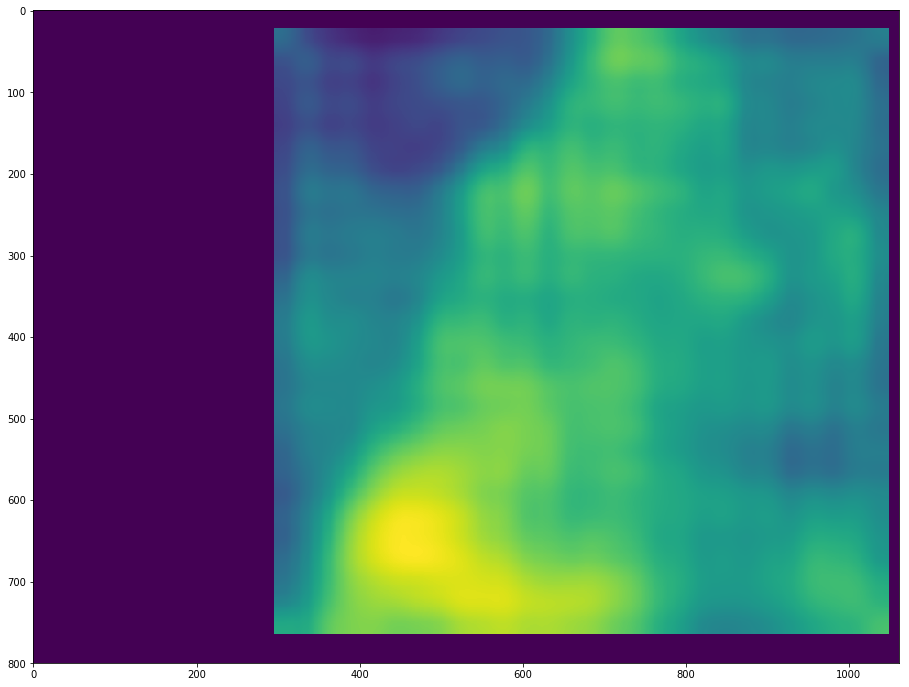

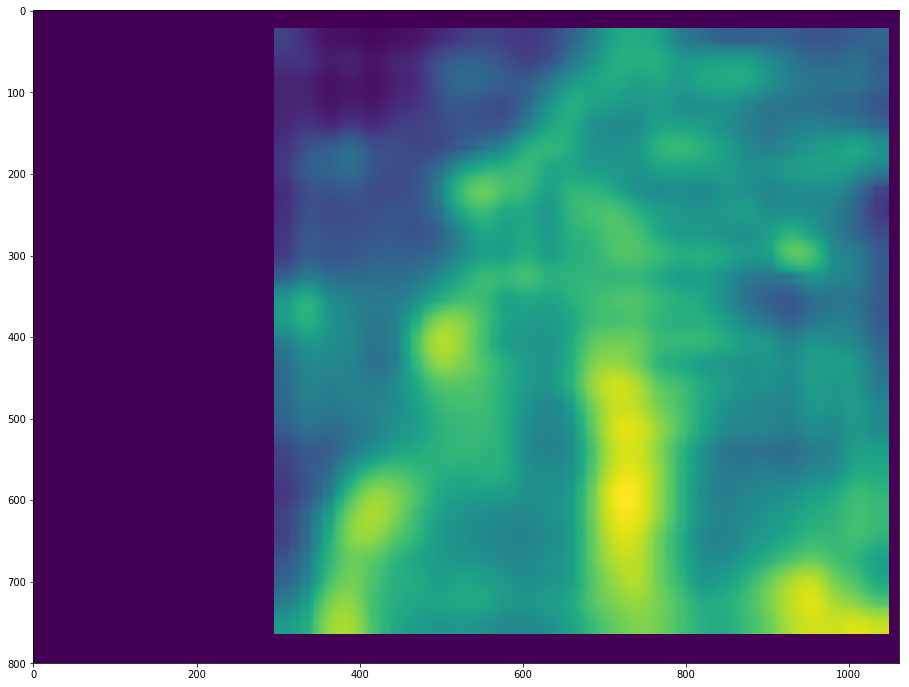

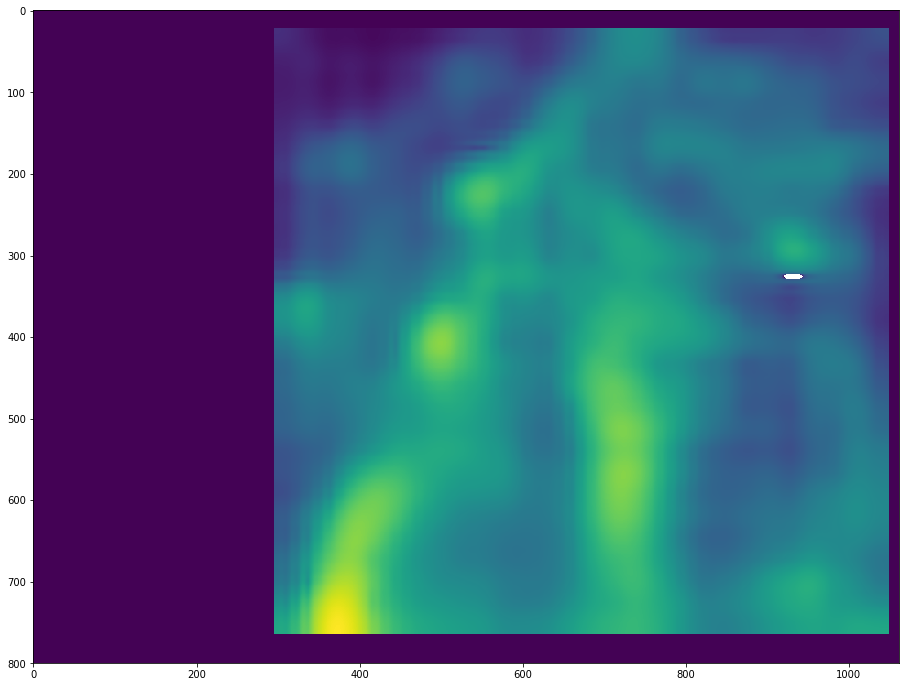

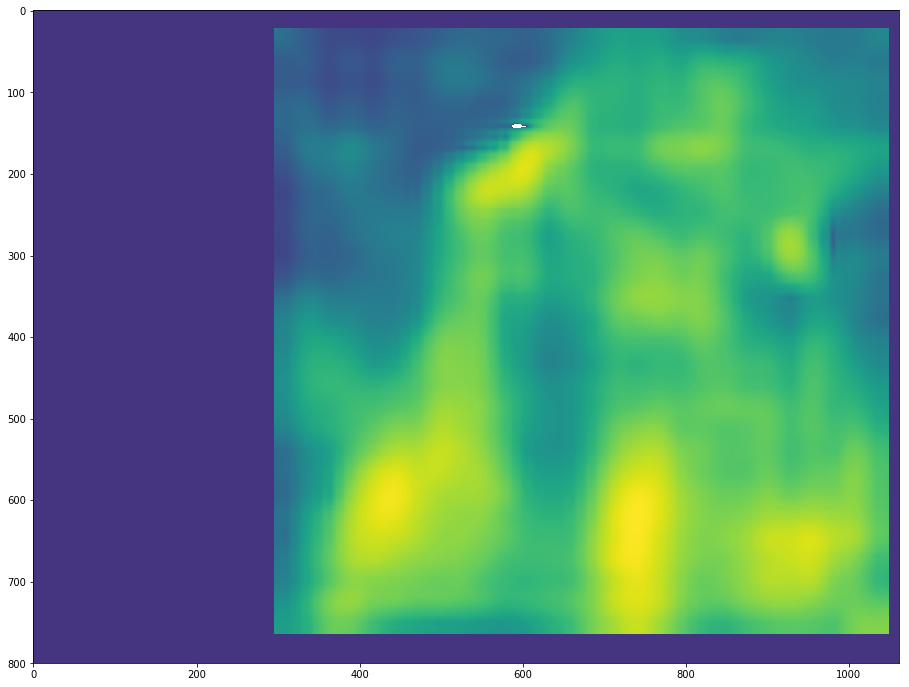

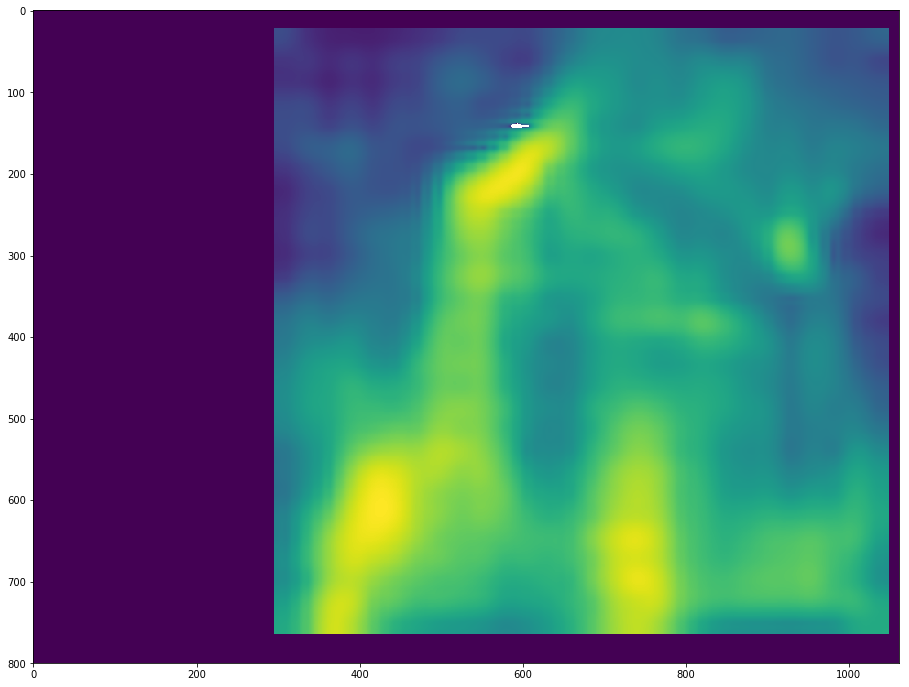

In [113]:
for i in range(17):
    plt.figure()
    plt.imshow((heatmap_channels[i]))

In [103]:
torch.min(prediction_plus)

tensor(-73.0104)

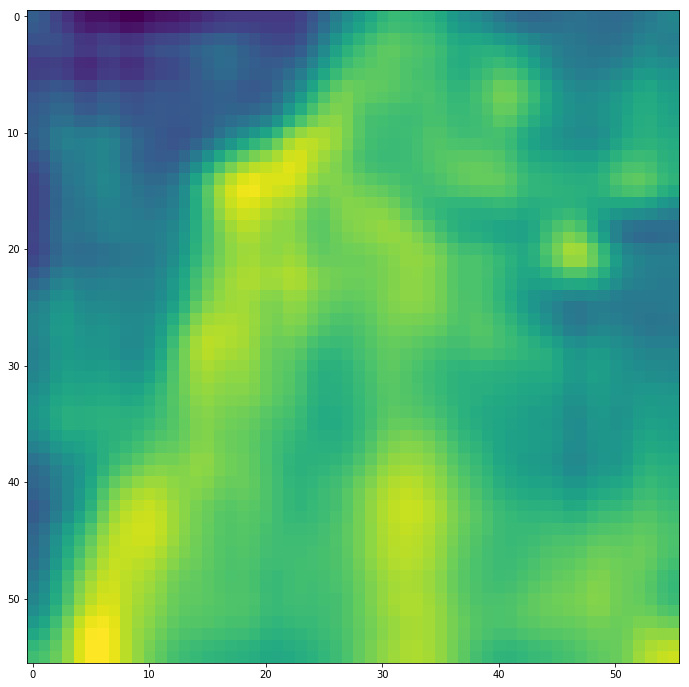

In [81]:
plt.figure()
plt.imshow(prediction_plus)

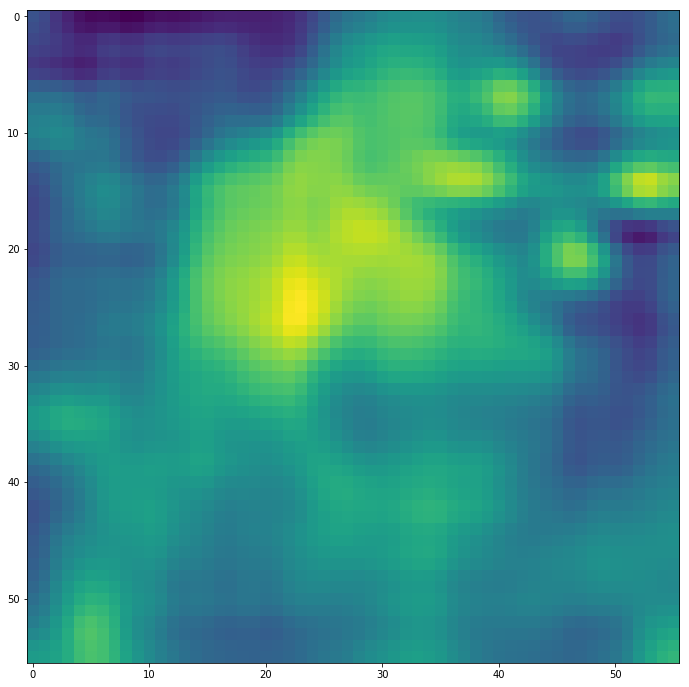

In [113]:
plt.figure()
plt.imshow(prediction_plus)

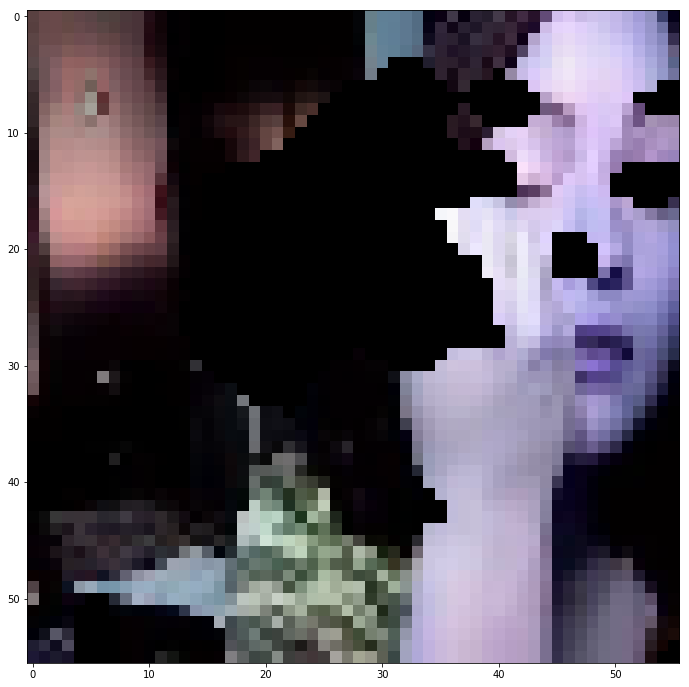

In [108]:
plt.figure()
plt.imshow(cv2.resize(np_img, (56,56), interpolation=cv2.INTER_CUBIC) * 
           (prediction_plus.numpy() < -34.5)[:,:,np.newaxis])


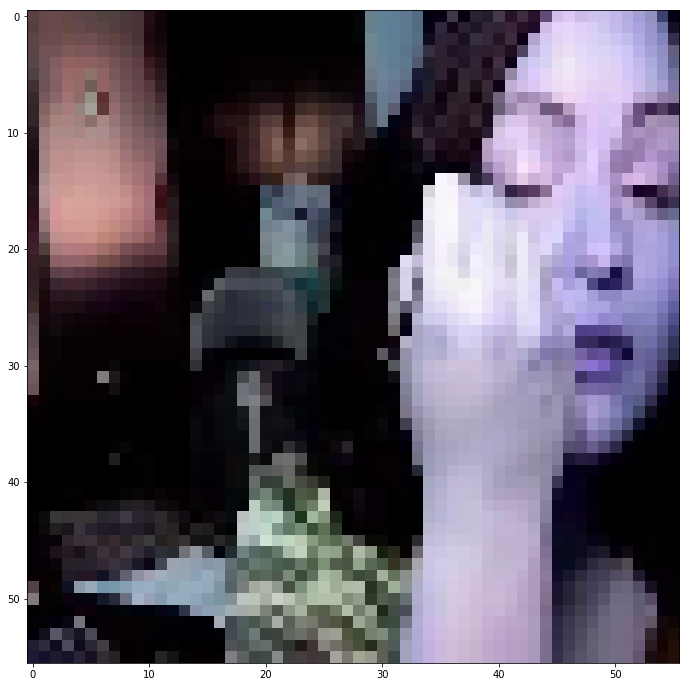

In [109]:
plt.figure()
plt.imshow(cv2.resize(np_img, (56,56), interpolation=cv2.INTER_CUBIC))

## Testing with one image and default predictor.py

In [18]:
img_path='ucf_test_img.jpg'
np_img=load_ucf(img_path)

predictions = coco_demo.compute_prediction(np_img)
top_predictions = coco_demo.select_top_predictions(predictions)

In generalized rcnn: initial proposals= 1000
In ROI Head: detections size= 5
In ROI Head: After updating loss box detections= 5
In ROIKeypointHead: Length of proposals before post processor= 5
In ROIKeypointHead: Length of proposals after post processor= 5
In predictor: length of proposals 5


In [19]:
len(predictions)

5

In [25]:
import torch
keypoints = predictions.get_field("keypoints")
kps = keypoints.keypoints
scores = keypoints.get_field("logits")
kps = torch.cat((kps[:, :, 0:2], scores[:, :, None]), dim=2).numpy()

In [26]:
kps

array([[[ 2.97118866e+02,  9.28555832e+01,  9.73528194e+00],
        [ 3.24308563e+02,  7.07906418e+01,  8.98307323e+00],
        [ 2.59053314e+02,  6.82323837e+01,  7.94842815e+00],
        [ 3.35504303e+02,  7.11104202e+01, -2.29033113e+00],
        [ 1.94437881e+02,  1.13961189e+02,  5.89538527e+00],
        [ 3.07035095e+02,  2.44112411e+02,  3.20267022e-01],
        [ 1.32701324e+02,  2.31960693e+02,  2.01983786e+00],
        [ 1.73645767e+02,  7.43082352e+01, -4.10226822e+00],
        [ 1.76524673e+02,  7.30291061e+01, -2.12307274e-02],
        [ 2.36661835e+02,  1.93586868e+02,  1.22740424e+00],
        [ 2.37301590e+02,  1.90389053e+02,  3.02137089e+00],
        [ 2.71208710e+02,  7.17499847e+01, -3.77495265e+00],
        [ 1.46775970e+02,  2.11814453e+02, -2.48263478e+00],
        [ 2.32503403e+02,  1.90389053e+02, -2.25603819e+00],
        [ 1.19906181e+02,  2.44112411e+02,  6.51891947e-01],
        [ 2.36981705e+02,  1.99662735e+02, -2.35227966e+00],
        [ 1.37179626e+02

In [31]:
kps.shape

(5, 17, 3)